# Can you create the best classifier? 

1. Use the file [`hatespeech_text_label_vote_RESTRICTED_100K.csv`](hatespeech_text_label_vote_RESTRICTED_100K.csv) that you can find in the current folder. You can also download the data [here](https://www.dropbox.com/sh/4mapojr85a6sc76/AABYMkjLVG-HhueAgd0qM9kwa?dl=0).

2. The data contain one column with tweets (their text only) and a column with a label (*Abusive, Hateful, Normal, Spam*). Calculate some descriptives (e.g., distribution of labels; most frequent words per label etc.)

3. Create machine learning classifiers to (a) identify spam; and (b) identify abusive and/or hateful tweets.


---

### Background info on the data

Find more information on this dataset here:
http://www.wikicfp.com/cfp/servlet/event.showcfp?eventid=99774&copyownerid=99078


Founta, Antigoni Maria, Constantinos Djouvas, Despoina Chatzakou, Ilias Leontiadis, Jeremy Blackburn, Gianluca Stringhini, Athena Vakali, Michael Sirivianos, and Nicolas Kourtellis. "*Large scale crowdsourcing and characterization of twitter abusive behavior.*" In Proceedings of the International AAAI Conference on Web and Social Media, 2018.

In [3]:
import csv
import re
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,ParameterGrid
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import f1_score, make_scorer, classification_report
import pandas as pd
from sklearn.metrics import classification_report

In [2]:
path = 'hatespeech_text_label_vote_RESTRICTED_100K.csv'

In [4]:
# load the tweet data
tweets = []
labels = []
with open(path) as fi:
    data = csv.reader(fi, delimiter='\t')
    for row in data:
        tweets.append(row[0])
        labels.append(row[1]) 

In [5]:
## sanity checks
print(len(tweets) == len(labels))
print(len(tweets))

True
99996


In [6]:
# Classes are imbalanced... this has implications for the training procedure.
Counter(labels)

Counter({'normal': 53851, 'abusive': 27150, 'spam': 14030, 'hateful': 4965})

<BarContainer object of 4 artists>

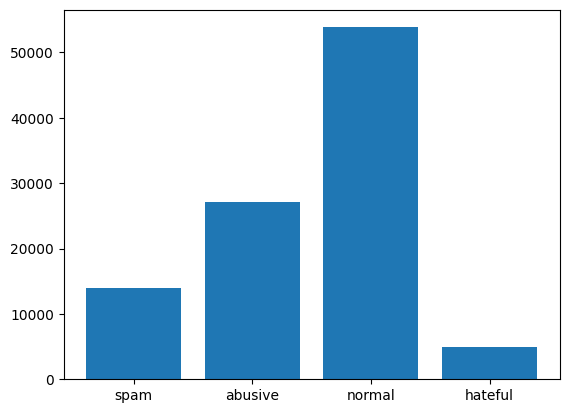

In [7]:
# Plot the number of tweets per class
plt.bar(Counter(labels).keys(), Counter(labels).values())

In [8]:
# 80/20 train/test split
X_train, X_test, y_train, y_test = train_test_split(tweets, labels, test_size=0.2, random_state=42) 

In [9]:
# Print a few tweets and labels to inspect the data
for i in range(5):
    print(f"Label: {y_train[i]}\nTweet: {X_train[i]}\n")

Label: abusive
Tweet: RT @paytons_hawtmom: I knew that girl was fucking Sierra husband &#128514;&#128514;&#128514; #LHHATL

Label: abusive
Tweet: RT @SheaSerrano: SHE FUCKING DID IT!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Label: normal
Tweet: What happened with all the people concerned about Flynn's alleged story? There was no Russian collusion glad that is over. #Trump #Russia

Label: normal
Tweet: When you are ready to make excuses and give up... Think of the adversity these folks overcome https://t.co/U06W3gPQBg

Label: normal
Tweet: @garyashley5 @sommecourt This is a much better picture (not mine - from Pinterest) https://t.co/NnlzSikEpK



In [10]:
# one example solution
pipeline = Pipeline(steps = [('vectorizer', TfidfVectorizer()), ('classifier', LogisticRegression(solver='liblinear'))])

grid = {
    'vectorizer__ngram_range' : [(1,1), (1,2)],
    'vectorizer__max_df': [0.5, 1.0],
    'vectorizer__min_df': [1, 5],
    'classifier__C': [0.01, 1, 100]
}



In [12]:
search = GridSearchCV(estimator=pipeline, # first vectorizer, then classifier
                      param_grid=grid, # test these parameters
                      scoring='f1_macro',     # optimise for macro f1 score (note: we want good performance for all classes )
                      cv=5, # 5-fold cross validation 
                      n_jobs=-3,  # use all cpus
                      verbose=1) # print some output
                      
search.fit(X_train, y_train)
print(f'Using these hyperparameters {search.best_params_}, we get the best performance.')


Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/rupertkiddle/opt/miniconda3/envs/gesis_iml/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Using these hyperparameters {'classifier__C': 100, 'vectorizer__max_df': 1.0, 'vectorizer__min_df': 1, 'vectorizer__ngram_range': (1, 2)}, we get the best performance.


In [ ]:
# Save the best model from the grid search
import joblib
joblib.dump(search.best_estimator_, 'best_model.pkl')

In [ ]:
print(classification_report(y_test, search.predict(X_test)))

#### Other options to try: 
- Different preprocessing steps (e.g., stopword removal, different tokenizers, stemming, lemmatization, ...)
- Different vectorizers (e.g. CountVectorizer())
- Different classifiers (e.g., MultinomialNB(), SVC())
- Class weights
- ...

In [ ]:
example_grid = {'vectorizer__stop_words':[None, stopwords], # stopword removal
        'vectorizer__max_df':[0.5, 1.0], # exclude terms in more than 50% or 100% of the docs
        'vectorizer__min_df':[1, 5], # exclude terms in less than 1 or 5 documents.
        'vectorizer__ngram_range':[(1,1), (1,2)], # consider only unigrams, or both unigrams and bigrams
        'vectorizer__preprocessor':[None, preprocess], # No preprocessing, or custom preprocessor function
        'vectorizer__tokenizer':[None, tokenizer], # word (=whitespace) or  tokenize is your custom tokenizer
        'classifier__class_weight':[None, 'balanced'] # class weights: None or balanced.
        }

In [13]:
#instantiate a tokenizer:
from nltk.tokenize import word_tokenize

# Example text
text = "Hello, world! This is a tokenizer example."

# Tokenize the text
tokens = word_tokenize(text)

In [14]:
tokens

['Hello', ',', 'world', '!', 'This', 'is', 'a', 'tokenizer', 'example', '.']